In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d imsparsh/gesture-recognition

! unzip "gesture-recognition.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00029.png  
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00031.png  
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00033.png  
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00035.png  
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00037.png  
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00039.png  
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00041.png  
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00043.png  
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_new/WIN_20180926_17_33_08_Pro_00045.png  
  inflating: train/WIN_20180926_17_33_08_Pro_Thumbs_Down_n

In [ ]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime

import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

import tensorflow as tf
print(tf.version)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.10/dist-packages/tensorflow/_api/v2/version/__init__.py'>


import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

In [ ]:
train_doc = np.random.permutation(open('dataset/train.csv').readlines())
val_doc = np.random.permutation(open('dataset/val.csv').readlines())
num_classes = 5

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = 'dataset/train'
val_path = 'dataset/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


In [ ]:
def plot_loss_accuracy(history):
    print(history.history.keys())
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [ ]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1)

    return [checkpoint, LR]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int)

        for batch in range(num_batches):
            batch_data   = np.zeros((batch_size, num_images, height, width, 3))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 # NORMALIZE ON EACH CHANNEL
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 # NORMALIZE ON EACH CHANNEL
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 # NORMALIZE ON EACH CHANNEL

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width, 3))
            batch_labels = np.zeros((remaining_batch_size,5))

            for folder in range(remaining_batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

In [ ]:
from keras.applications import mobilenet

def mobilenet_RNN(cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(GRU(cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam()
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [ ]:
num_epochs = 15
batch_size = 32
num_frames = 20
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames)
print (model.summary())

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 3, 3, 1024)    3228864   
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
                                                         

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, augment=True)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-9-7e9bc46ddd2a>:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


KeyboardInterrupt: 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


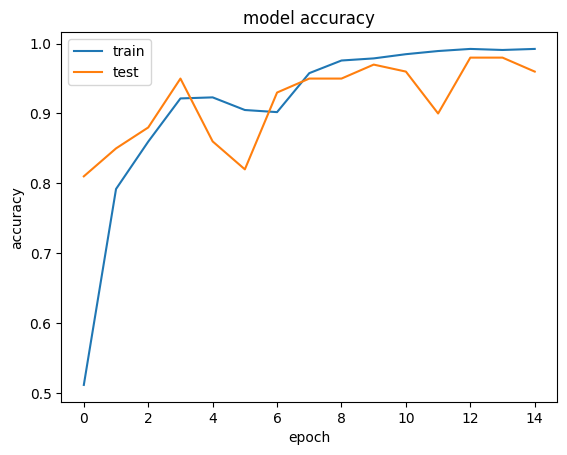

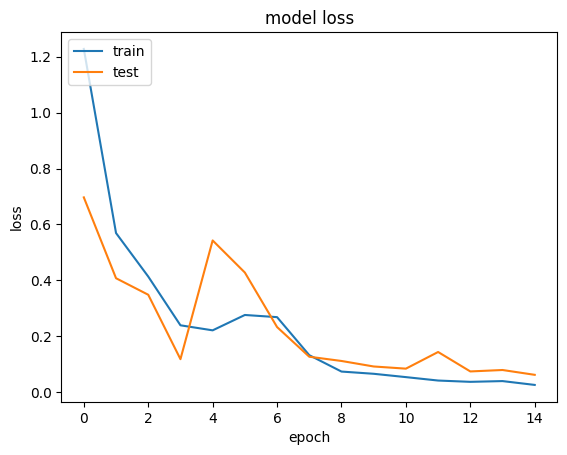

In [ ]:
plot_loss_accuracy(history)

In [ ]:
def mobilenet_RNN(cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam()
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [ ]:
num_epochs = 10
batch_size = 32
num_frames = 20
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames)
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 20, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)              

In [ ]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, augment=True)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-10-fcb894558a0f>:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/10
18/21 [========================>.....] - ETA: 3:01 - loss: 1.3078 - categorical_accuracy: 0.4340

<ipython-input-10-fcb894558a0f>:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


21/21 [==============================] - ETA: 0s - loss: 1.2536 - categorical_accuracy: 0.4676  
Epoch 1: val_loss improved from inf to 1.02625, saving model to model_retrain_mobilenet_lstm_2024-06-0310_02_45.279905/model-00001-1.25362-0.46757-1.02625-0.59000.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 1382s 64s/step - loss: 1.2536 - categorical_accuracy: 0.4676 - val_loss: 1.0262 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.5055 - categorical_accuracy: 0.7903  
Epoch 2: val_loss did not improve from 1.02625
21/21 [==============================] - 1354s 65s/step - loss: 0.5055 - categorical_accuracy: 0.7903 - val_loss: 1.0621 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.3259 - categorical_accuracy: 0.8854  
Epoch 3: val_loss improved from 1.02625 to 0.49192, saving model to model_retrain_mobilenet_lstm_2024-06-0310_02_45.279905/model-00003-0.32586-0.88537-0.49192-0.78000.h5
21/21 [==============================] - 1338s 64s/step - loss: 0.3259 - categorical_accuracy: 0.8854 - val_loss: 0.4919 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 4/10
21/21 [==============================] - ETA: 0s 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


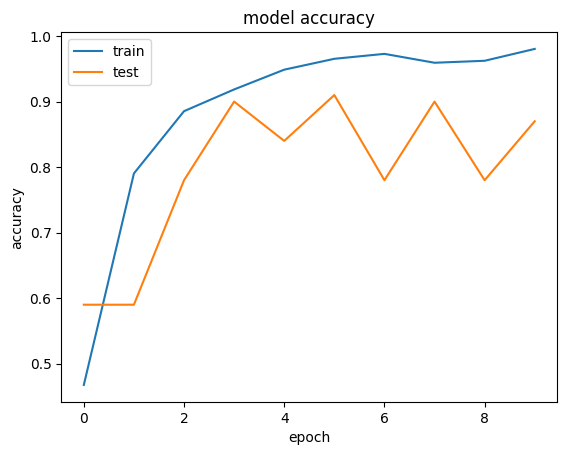

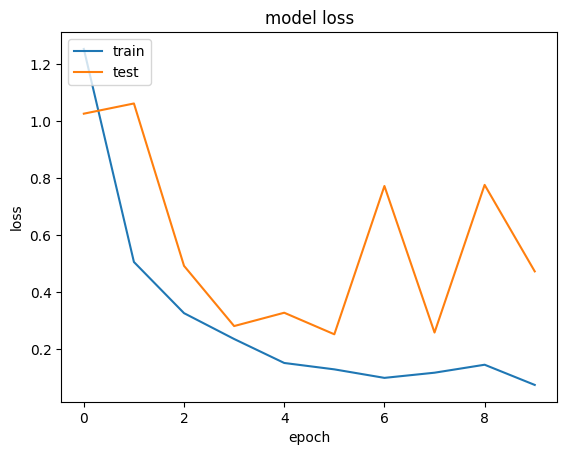

In [ ]:
plot_loss_accuracy(history)

In [ ]:
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
num_epochs = 15
batch_size = 16
num_frames = 30
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16   6016      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_2 (Bat  (None, 30, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 60, 60, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)   

In [ ]:
callbacks_list = model_callbacks("model_conv3D")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-9-7e9bc46ddd2a>:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15


KeyboardInterrupt: 